In [1]:
!pip install torchinfo

### Import Libraries

In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate
from torchsummary import summary

### Configuration

In [3]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [5]:
data_dir = "/kaggle/input/fruit-vision/Fruits Original"

file_paths = []
labels = []

valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')

for fruit in os.listdir(data_dir):
    fruit_dir = os.path.join(data_dir, fruit)
    if not os.path.isdir(fruit_dir):
        continue
    for condition in os.listdir(fruit_dir):
        condition_dir = os.path.join(fruit_dir, condition)
        if not os.path.isdir(condition_dir):
            continue
        for file_name in os.listdir(condition_dir):
            if file_name.lower().endswith(valid_extensions):
                file_path = os.path.join(condition_dir, file_name)
                if os.path.isfile(file_path):
                    file_paths.append(file_path)
                    labels.append(f"{fruit}_{condition}")

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

df.head()

,file_path,label
0,/kaggle/input/fruit-vision/Fruits Original/App...,Apple_Rotten
1,/kaggle/input/fruit-vision/Fruits Original/App...,Apple_Formalin-mixed
2,/kaggle/input/fruit-vision/Fruits Original/Man...,Mango_Fresh
3,/kaggle/input/fruit-vision/Fruits Original/Man...,Mango_Fresh
4,/kaggle/input/fruit-vision/Fruits Original/Ora...,Orange_Fresh


Class: Grape_Fresh, Count: 770
Class: Apple_Fresh, Count: 765
Class: Mango_Fresh, Count: 763
Class: Orange_Fresh, Count: 753
Class: Banana_Fresh, Count: 749
Class: Banana_Formalin-mixed, Count: 660
Class: Orange_Rotten, Count: 656
Class: Orange_Formalin-mixed, Count: 647
Class: Apple_Formalin-mixed, Count: 643
Class: Banana_Rotten, Count: 632
Class: Apple_Rotten, Count: 630
Class: Grape_Rotten, Count: 630
Class: Mango_Rotten, Count: 630
Class: Mango_Formalin-mixed, Count: 616
Class: Grape_Formalin-mixed, Count: 610


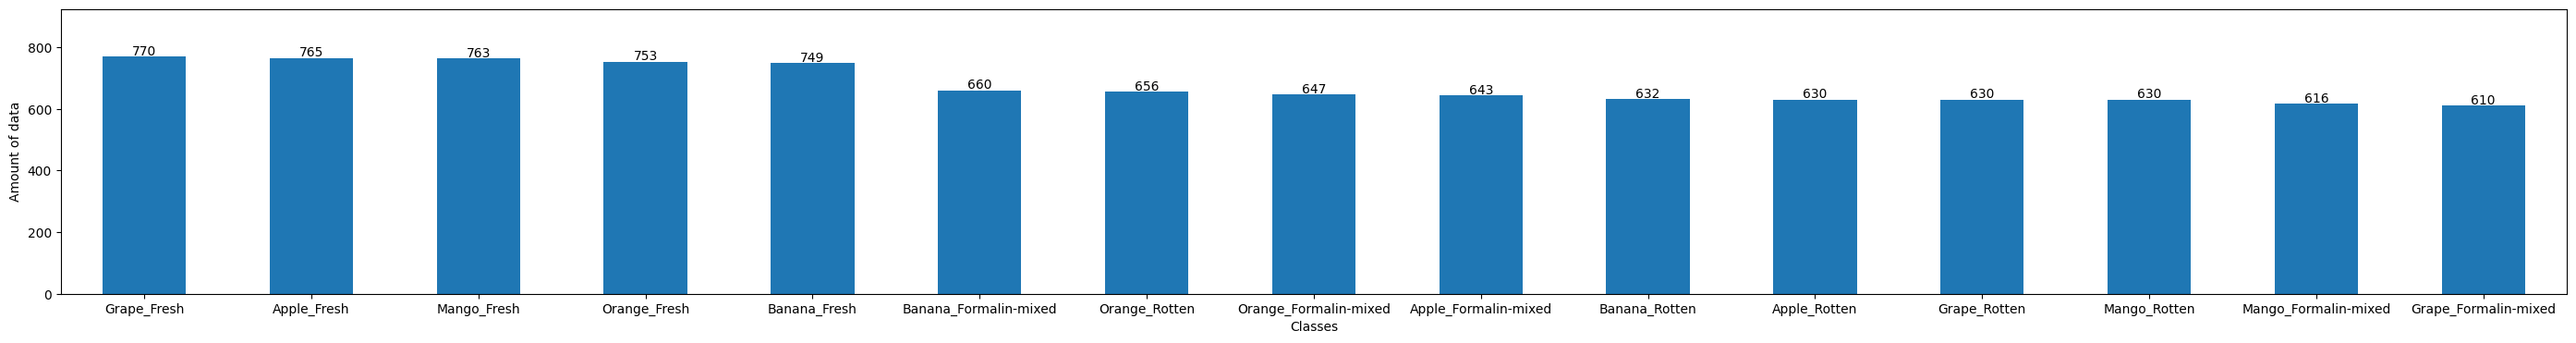

In [7]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(35, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

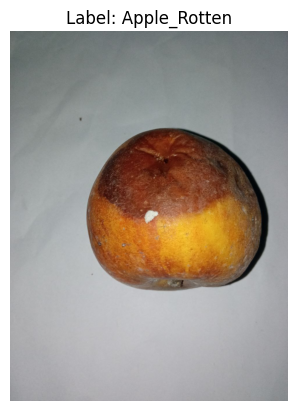

In [8]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [9]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [10]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  7107
Validation Data:  1523
Test Data:  1524
-------------------------------------------
Total amounts of data in the dataset:  10154


In [11]:
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                    Count
---------------------  -------
Grape_Fresh                539
Apple_Fresh                536
Mango_Fresh                534
Orange_Fresh               527
Banana_Fresh               524
Banana_Formalin-mixed      462
Orange_Rotten              459
Orange_Formalin-mixed      453
Apple_Formalin-mixed       450
Banana_Rotten              442
Apple_Rotten               441
Grape_Rotten               441
Mango_Rotten               441
Mango_Formalin-mixed       431
Grape_Formalin-mixed       427

Validation Dataset
Class                    Count
---------------------  -------
Grape_Fresh                115
Apple_Fresh                114
Mango_Fresh                114
Orange_Fresh               113
Banana_Fresh               112
Banana_Formalin-mixed       99
Orange_Rotten               98
Orange_Formalin-mixed       97
Apple_Formalin-mixed        96
Mango_Rotten                95
Banana_Rotten               95
Grape_Rotten                95
Apple

### Device Variable

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Checkpoint

In [14]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

# Data Transfer

In [15]:
# Build the label map from your combined labels (e.g. Apple_Fresh, etc.)
unique_labels = sorted(df['label'].unique())
label_map = {label: idx for idx, label in enumerate(unique_labels)}
total_class = len(label_map)  # <- pass this to model.fc

### Dataset Class, Dataloader and Transform

In [16]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, label_map, is_lb=True):
        self.dataframe = dataframe
        self.normalize = normalize
        self.label_map = label_map  
        self.is_lb = is_lb

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = Image.open(img_path).convert('RGB')  

        if self.is_lb:
            label_str = self.dataframe.iloc[index]['label']
            label = self.label_map[label_str]  
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [17]:
train_batch = 32
val_batch = 8

def data_transform(label_map):
    normalize = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    train_dataset = ImageDataset(
        dataframe=train_dataframe,
        normalize=normalize,
        label_map=label_map,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        dataframe=valid_dataframe,
        normalize=normalize,
        label_map=label_map,
        is_lb=True
    )

    test_dataset = ImageDataset(
        dataframe=test_df,
        normalize=normalize,
        label_map=label_map,
        is_lb=True
    )

    dataloader_train = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, num_workers=2)
    dataloader_valid = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False, num_workers=2)
    dataloader_test = DataLoader(test_dataset, batch_size=val_batch, shuffle=False, num_workers=2)

    return dataloader_train, dataloader_valid, dataloader_test

In [18]:
dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transform(label_map)


### C.N.N

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader

train_batch = 32
val_batch = 8
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_class = len(label_map)


#Model
class myyCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(myyCNN, self).__init__()
        
        # Convolutional layers + BatchNorm
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # compatible with 224x224 input
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        out = self.fc2(x)
        return out
    
    def extract_features(self, x):
        # Forward until fc1 (feature vector)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        features = F.relu(self.fc1(x))  # 512-dim feature vector
        return features


model = myyCNN(num_classes=total_class).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
       BatchNorm2d-5         [-1, 64, 112, 112]             128
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
       BatchNorm2d-8          [-1, 128, 56, 56]             256
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Linear-10                  [-1, 512]      51,380,736
          Dropout-11                  [-1, 512]               0
           Linear-12                   [-1, 15]           7,695
Total params: 51,482,127
Trainable params: 51,482,127
Non-trainable params: 0
-------------------------

### Training

In [20]:
start_time = time.time()
def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=20,  save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0


    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, save_path_checkpoints=save_path_checkpoints)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/20: 100%|██████████| 223/223 [01:57<00:00,  1.90it/s, acc=0.574, loss=1.33]

Training Loss: 1.327 Acc: 0.574


Validation Loss: 0.541 Acc: 0.794
Best model saved at epoch 1 with validation accuracy: 0.794


Epoch 2/20: 100%|██████████| 223/223 [01:28<00:00,  2.51it/s, acc=0.733, loss=0.724]

Training Loss: 0.724 Acc: 0.733


Validation Loss: 0.491 Acc: 0.809
Best model saved at epoch 2 with validation accuracy: 0.809


Epoch 3/20: 100%|██████████| 223/223 [01:27<00:00,  2.55it/s, acc=0.789, loss=0.565]

Training Loss: 0.565 Acc: 0.789


Validation Loss: 0.398 Acc: 0.839
Best model saved at epoch 3 with validation accuracy: 0.839


Epoch 4/20: 100%|██████████| 223/223 [01:26<00:00,  2.57it/s, acc=0.817, loss=0.482]

Training Loss: 0.482 Acc: 0.817


Validation Loss: 0.341 Acc: 0.865
Best model saved at epoch 4 with validation accuracy: 0.865


Epoch 5/20: 100%|██████████| 223/223 [01:25<00:00,  2.60it/s, acc=0.845, loss=0.422]

Training Loss: 0.422 Acc: 0.845


Validation Loss: 0.290 Acc: 0.892
Best model saved at epoch 5 with validation accuracy: 0.892


Epoch 6/20: 100%|██████████| 223/223 [01:27<00:00,  2.56it/s, acc=0.849, loss=0.4]  

Training Loss: 0.400 Acc: 0.849


Validation Loss: 0.263 Acc: 0.895
Best model saved at epoch 6 with validation accuracy: 0.895


Epoch 7/20: 100%|██████████| 223/223 [01:26<00:00,  2.58it/s, acc=0.874, loss=0.329]

Training Loss: 0.329 Acc: 0.874


Validation Loss: 0.278 Acc: 0.889


Epoch 8/20: 100%|██████████| 223/223 [01:26<00:00,  2.57it/s, acc=0.885, loss=0.307]

Training Loss: 0.307 Acc: 0.885


Validation Loss: 0.367 Acc: 0.866


Epoch 9/20: 100%|██████████| 223/223 [01:27<00:00,  2.55it/s, acc=0.887, loss=0.286]

Training Loss: 0.286 Acc: 0.887


Validation Loss: 0.367 Acc: 0.865


Epoch 10/20: 100%|██████████| 223/223 [01:26<00:00,  2.57it/s, acc=0.896, loss=0.269]

Training Loss: 0.269 Acc: 0.896


Validation Loss: 0.241 Acc: 0.899
Best model saved at epoch 10 with validation accuracy: 0.899


Epoch 11/20: 100%|██████████| 223/223 [01:27<00:00,  2.56it/s, acc=0.901, loss=0.258]

Training Loss: 0.258 Acc: 0.901


Validation Loss: 0.252 Acc: 0.908
Best model saved at epoch 11 with validation accuracy: 0.908


Epoch 12/20: 100%|██████████| 223/223 [01:27<00:00,  2.56it/s, acc=0.917, loss=0.223]

Training Loss: 0.223 Acc: 0.917


Validation Loss: 0.236 Acc: 0.902


Epoch 13/20: 100%|██████████| 223/223 [01:26<00:00,  2.58it/s, acc=0.916, loss=0.214]

Training Loss: 0.214 Acc: 0.916


Validation Loss: 0.252 Acc: 0.901


Epoch 14/20: 100%|██████████| 223/223 [01:27<00:00,  2.56it/s, acc=0.92, loss=0.215] 

Training Loss: 0.215 Acc: 0.920


Validation Loss: 0.215 Acc: 0.919
Best model saved at epoch 14 with validation accuracy: 0.919


Epoch 15/20: 100%|██████████| 223/223 [01:26<00:00,  2.59it/s, acc=0.92, loss=0.207] 

Training Loss: 0.207 Acc: 0.920


Validation Loss: 0.253 Acc: 0.906


Epoch 16/20: 100%|██████████| 223/223 [01:26<00:00,  2.56it/s, acc=0.924, loss=0.201]

Training Loss: 0.201 Acc: 0.924


Validation Loss: 0.261 Acc: 0.902


Epoch 17/20: 100%|██████████| 223/223 [01:28<00:00,  2.51it/s, acc=0.935, loss=0.173]

Training Loss: 0.173 Acc: 0.935


Validation Loss: 0.235 Acc: 0.923
Best model saved at epoch 17 with validation accuracy: 0.923


Epoch 18/20: 100%|██████████| 223/223 [01:27<00:00,  2.55it/s, acc=0.936, loss=0.174]

Training Loss: 0.174 Acc: 0.936


Validation Loss: 0.251 Acc: 0.912


Epoch 19/20: 100%|██████████| 223/223 [01:27<00:00,  2.54it/s, acc=0.94, loss=0.156] 

Training Loss: 0.156 Acc: 0.940


Validation Loss: 0.323 Acc: 0.884


Epoch 20/20: 100%|██████████| 223/223 [01:27<00:00,  2.56it/s, acc=0.933, loss=0.173]

Training Loss: 0.173 Acc: 0.933


Validation Loss: 0.264 Acc: 0.909
Training Time: 2162.35 seconds ---> 36.04 minutes


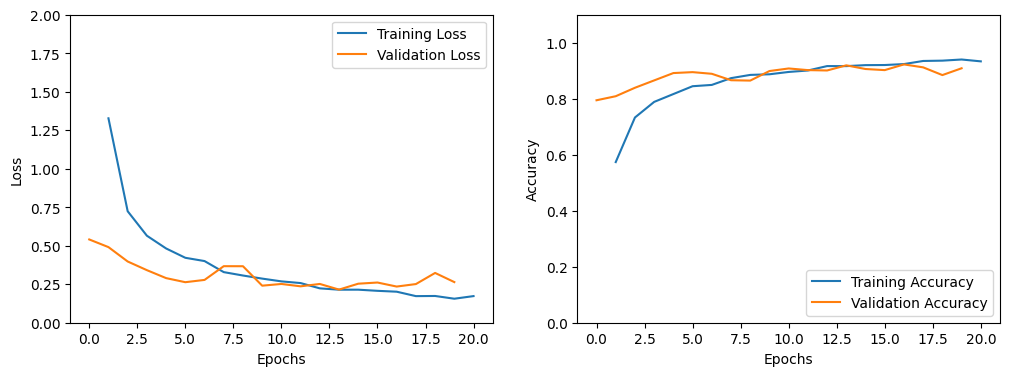

In [21]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Execution Model ML

In [22]:
# ML Classifiers on CNN Features
import numpy as np
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import time
from tqdm import tqdm

model.eval()

# Helper: extract features from dataset
def extract_features(dataloader, model):
    features_list = []
    labels_list = []
    with torch.no_grad():
        for imgs, labels in tqdm(dataloader):
            imgs = imgs.to(device)
            features = model.extract_features(imgs)  # use your extract_features method
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.numpy())
    X = np.concatenate(features_list, axis=0)
    y = np.concatenate(labels_list, axis=0)
    return X, y

# Extract features
X_train, y_train = extract_features(dataloader_train_dataset, model)
X_valid, y_valid = extract_features(dataloader_valid_dataset, model)
X_test, y_test = extract_features(dataloader_test_dataset, model)


# Define classifiers
classifiers = {
    "SVM": SVC(kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}



# Train and evaluate
results = {}
for name, clf in classifiers.items():
    start_time = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = clf.predict(X_test)
    test_time = time.time() - start_time
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, digits=4)
    cm = confusion_matrix(y_test, y_pred)
    
    results[name] = {
        "accuracy": acc,
        "classification_report": report,
        "confusion_matrix": cm,
        "train_time": train_time,
        "test_time": test_time
    }
    
    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Training Time: {train_time:.2f}s, Testing Time: {test_time:.2f}s")
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", cm)


100%|██████████| 191/191 [00:26<00:00,  7.18it/s]



SVM Results:
Accuracy: 0.9180
Training Time: 7.14s, Testing Time: 1.18s
Classification Report:
               precision    recall  f1-score   support

           0     0.8350    0.8866    0.8600        97
           1     0.8547    0.8696    0.8621       115
           2     0.9540    0.8830    0.9171        94
           3     0.8879    0.9596    0.9223        99
           4     0.9533    0.9027    0.9273       113
           5     0.9780    0.9368    0.9570        95
           6     0.9070    0.8571    0.8814        91
           7     0.8952    0.9569    0.9250       116
           8     0.9022    0.8830    0.8925        94
           9     0.9091    0.9783    0.9424        92
          10     0.9909    0.9478    0.9689       115
          11     0.9677    0.9574    0.9626        94
          12     0.8713    0.9072    0.8889        97
          13     0.9099    0.8938    0.9018       113
          14     0.9792    0.9495    0.9641        99

    accuracy                         

### Evaluation ML

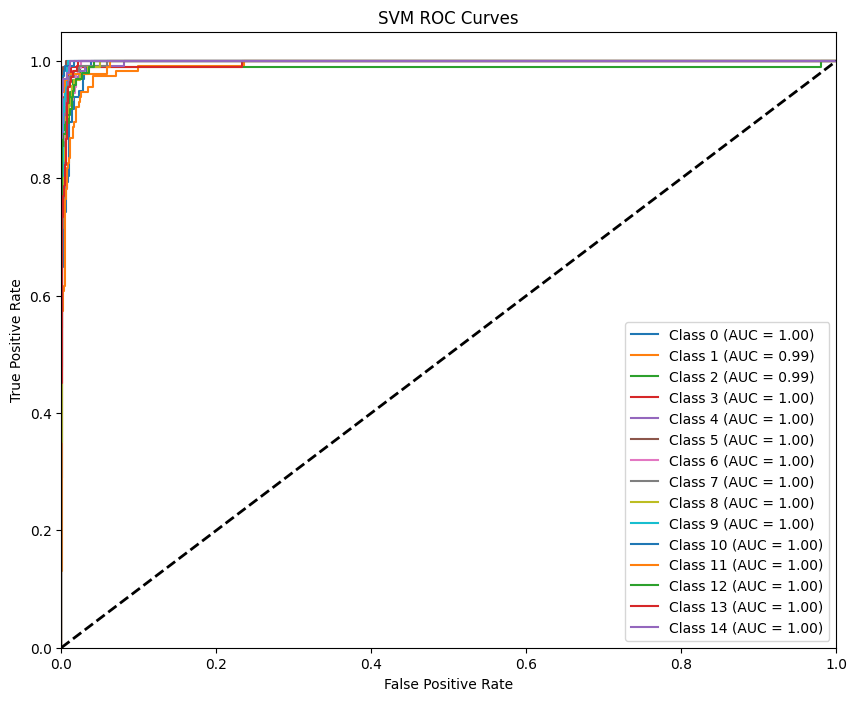


SVM Final Accuracy: 0.9180


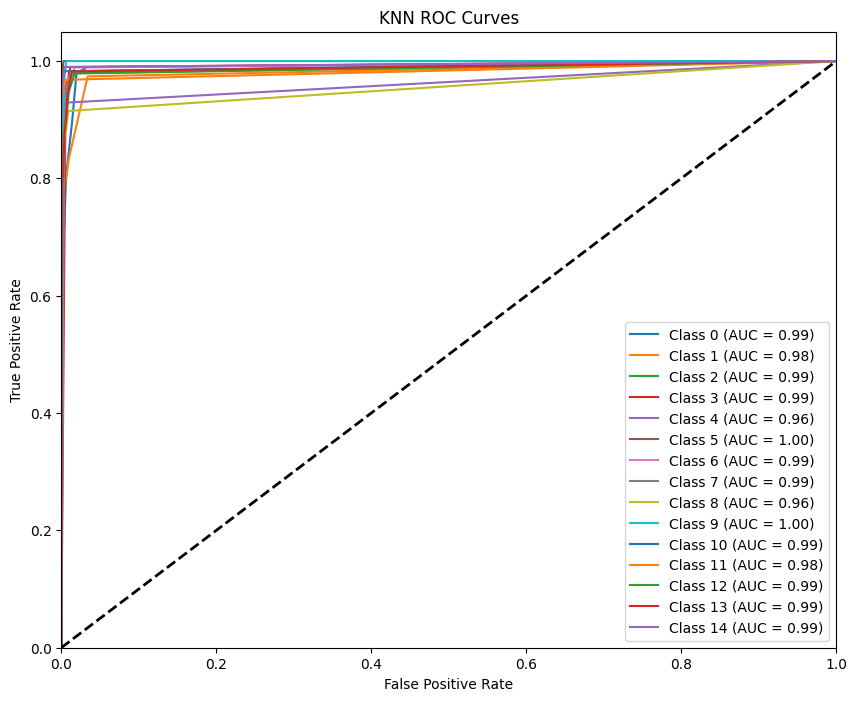


KNN Final Accuracy: 0.9226


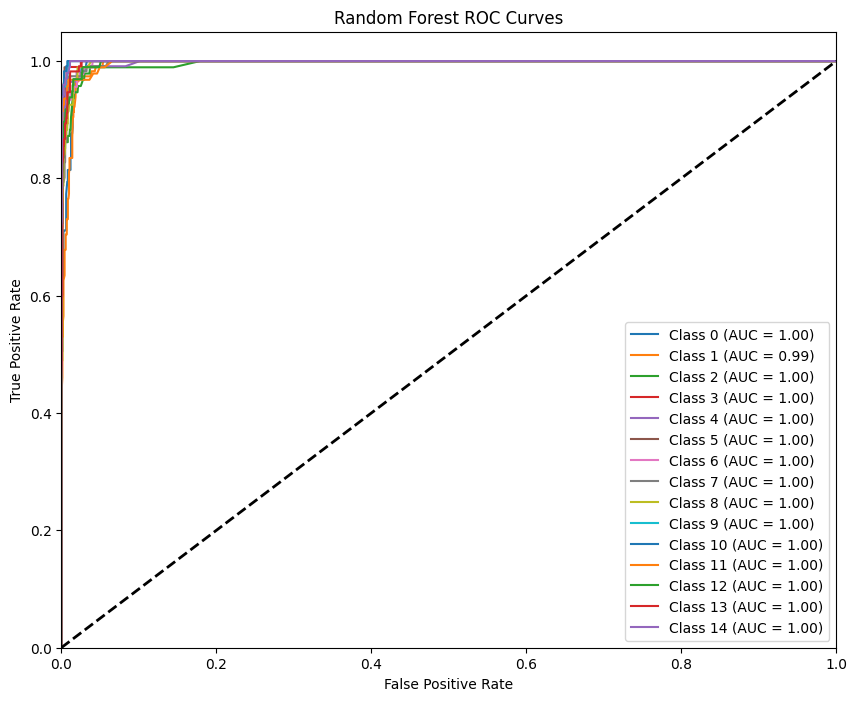


Random Forest Final Accuracy: 0.9127


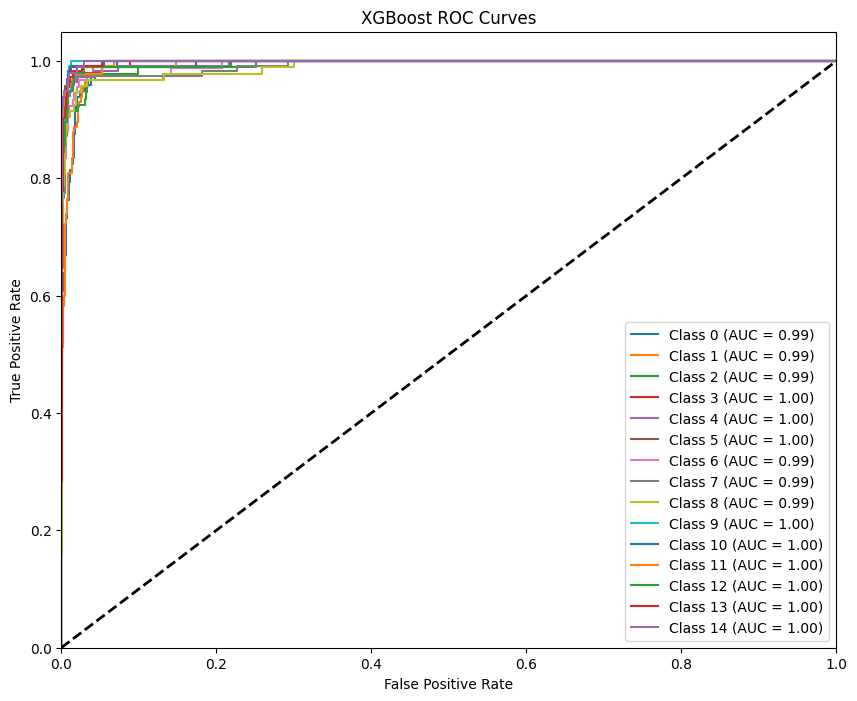


XGBoost Final Accuracy: 0.9003


In [26]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

#ROC Curves and AUC class for each classifier
n_classes = total_class 
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

for name, clf in classifiers.items():
    y_score = None
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)
    elif hasattr(clf, "decision_function"):
        y_score = clf.decision_function(X_test)
    
    if y_score is None:
        print(f"{name} does not support probability scores for ROC/AUC.")
        continue

    #Compute ROC curve and AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #ROC curves
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} ROC Curves")
    plt.legend(loc="lower right")
    plt.show()
    
    #print metrics
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Final Accuracy: {acc:.4f}")


### Evaluation

In [23]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [24]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 17) - Validation Loss: 0.235, Validation Accuracy: 0.923


In [27]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.914
Test Time: 17.05 seconds ---> 0.28 minutes


In [28]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        97
           1       0.88      0.89      0.88       115
           2       0.95      0.84      0.89        94
           3       0.90      0.95      0.92        99
           4       0.96      0.91      0.94       113
           5       0.98      0.95      0.96        95
           6       0.86      0.95      0.90        91
           7       0.91      0.93      0.92       116
           8       0.94      0.83      0.88        94
           9       0.94      0.92      0.93        92
          10       0.93      0.98      0.95       115
          11       0.98      0.94      0.96        94
          12       0.88      0.89      0.88        97
          13       0.87      0.92      0.89       113
          14       0.97      0.91      0.94        99

    accuracy                           0.91      1524
   macro avg       0.92      0.91      0.91      1524
wei

### Grad CAM

In [38]:
import torch
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx=None):
        """
        x: input tensor, shape (B, C, H, W)
        class_idx: list of integers (B length) or None for predicted classes
        """
        x = x.to(next(self.model.parameters()).device)  # ensure same device as model
        self.model.zero_grad()
        output = self.model(x)

        # If class_idx is None, use predicted classes
        if class_idx is None:
            class_idx = output.argmax(dim=1)

        # Make sure class_idx is a tensor on same device
        if not isinstance(class_idx, torch.Tensor):
            class_idx = torch.tensor(class_idx, device=x.device)

        # Compute gradients
        loss = output.gather(1, class_idx.view(-1,1)).squeeze()
        loss.backward(torch.ones_like(loss), retain_graph=True)

        # Compute weights
        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        grad_cam_map = (weights * self.activations).sum(dim=1, keepdim=True)
        grad_cam_map = F.relu(grad_cam_map)

        # Resize to input size
        grad_cam_map = F.interpolate(
            grad_cam_map, size=(x.size(2), x.size(3)),
            mode='bilinear', align_corners=False
        )

        # Normalize per sample
        maps = []
        for i in range(grad_cam_map.size(0)):
            m = grad_cam_map[i,0].cpu().numpy()
            m = (m - m.min()) / (m.max() - m.min() + 1e-8)
            maps.append(m)
        return maps if len(maps) > 1 else maps[0]


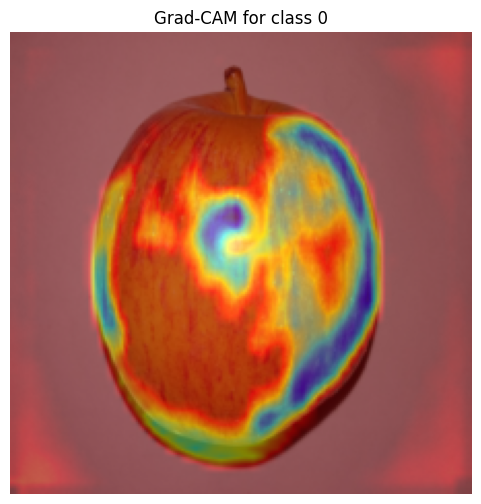

In [42]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Pick a single image from test DataLoader
image_batch, label_batch = next(iter(dataloader_test_dataset))
image_tensor = image_batch[0].unsqueeze(0).to(device)  # add batch dim
true_label = label_batch[0].item()

# Initialize Grad-CAM for last conv layer
grad_cam = GradCAM(model, model.conv3)

# Generate Grad-CAM heatmap
cam_map = grad_cam(image_tensor, class_idx=[true_label])

# Convert tensor image to numpy (HWC) for overlay
img_np = image_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # normalize 0-1

# Resize CAM map to match image size
cam_map_resized = cv2.resize(cam_map, (img_np.shape[1], img_np.shape[0]))

# Overlay heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam_map_resized), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
overlayed_img = heatmap + np.float32(img_np)
overlayed_img = overlayed_img / overlayed_img.max()

plt.figure(figsize=(6,6))
plt.imshow(overlayed_img)
plt.axis('off')
plt.title(f"Grad-CAM for class {true_label}")
plt.show()


### Confusion Metrix

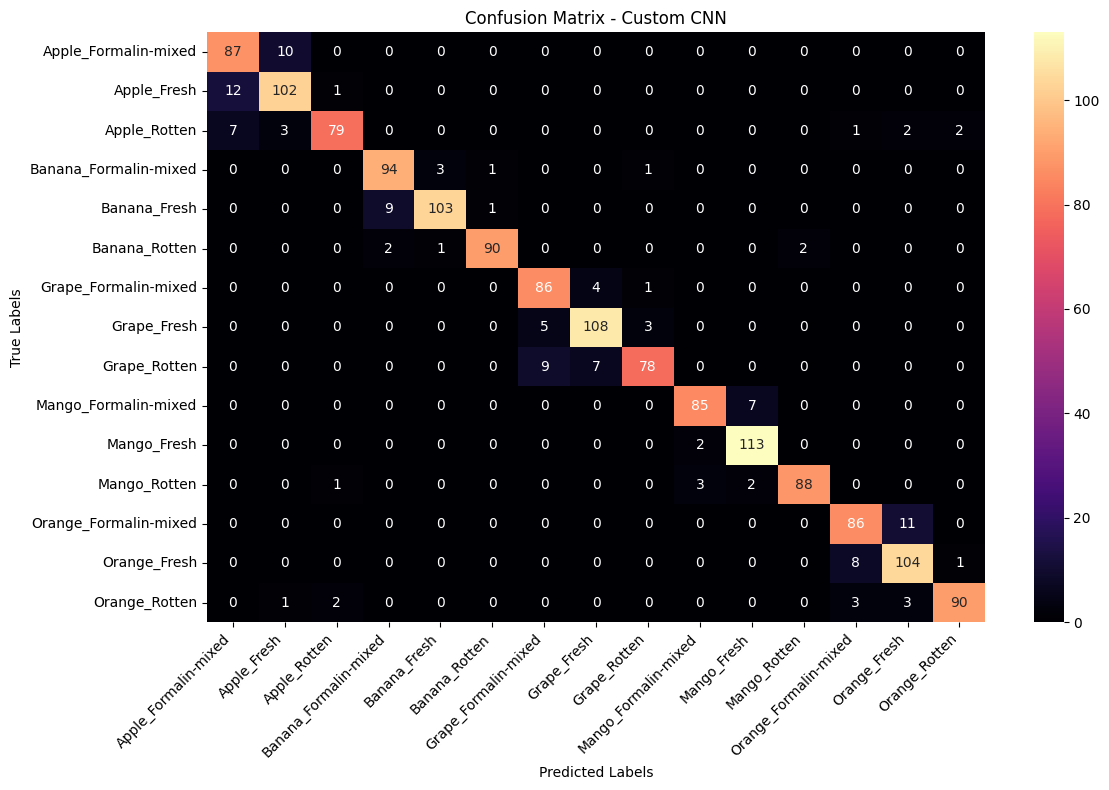

In [43]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


class_names = [
    "Apple_Formalin-mixed", "Apple_Fresh", "Apple_Rotten",
    "Banana_Formalin-mixed", "Banana_Fresh", "Banana_Rotten",
    "Grape_Formalin-mixed", "Grape_Fresh", "Grape_Rotten",
    "Mango_Formalin-mixed", "Mango_Fresh", "Mango_Rotten",
    "Orange_Formalin-mixed", "Orange_Fresh", "Orange_Rotten"
]


cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma", 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Custom CNN')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
